# Lobbying Influence Analysis

This notebook focuses on analyzing the relationship between money and congressional voting patterns.

### Focus Areas:
1. **Member vs Contributor Ideology Scatter** - Shows ideological + behavioral alignment. High predictive value.
2. **Contribution Amount vs Money Alignment** - Shows whether more money buys closer ideological match. Helps threshold modeling.
3. **Money-Vote Correlation by Policy Area** - Critical for engineering per-domain influence features. Tells you where money matters most.


In [7]:
import sys
sys.path.append("../..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

from src.data_loaders.rollcall import get_individual_votes_with_party_enriched_lobby

plt.style.use('default')
sns.set_palette("husl")

print("Setup complete")


Setup complete


## Data Loading & Preparation


In [3]:
# Load enriched voting data with lobbying information
print("Loading voting data with financial information...")
df_financial = get_individual_votes_with_party_enriched_lobby().reset_index()

print(f"✓ Financial voting data: {df_financial.shape}")
print(f"✓ Unique members: {df_financial['icpsr'].nunique():,}")

# Focus on recent data with financial information
df_recent = df_financial[df_financial['congress'] >= 110].copy()
df_recent = df_recent.dropna(subset=['personal_cfscore', 'contributor_cfscore'])

print(f"✓ Analysis dataset: {len(df_recent):,} records")
print(f"✓ Members with financial data: {df_recent['icpsr'].nunique():,}")

# Prepare member-level data for visualization 1
member_alignment = df_recent.groupby('icpsr').agg({
    'personal_cfscore': 'first',
    'contributor_cfscore': 'first',
}).round(3)

member_alignment['votes_with_money'] = (
    (member_alignment['personal_cfscore'] > 0) == 
    (member_alignment['contributor_cfscore'] > 0)
).astype(int)

print(f"✓ Members voting with money: {member_alignment['votes_with_money'].mean():.1%}")


Loading voting data with financial information...
✓ Financial voting data: (2823025, 121)
✓ Unique members: 1,623
✓ Analysis dataset: 1,274,521 records
✓ Members with financial data: 981
✓ Members voting with money: 98.8%


Creating ideology alignment visualization...


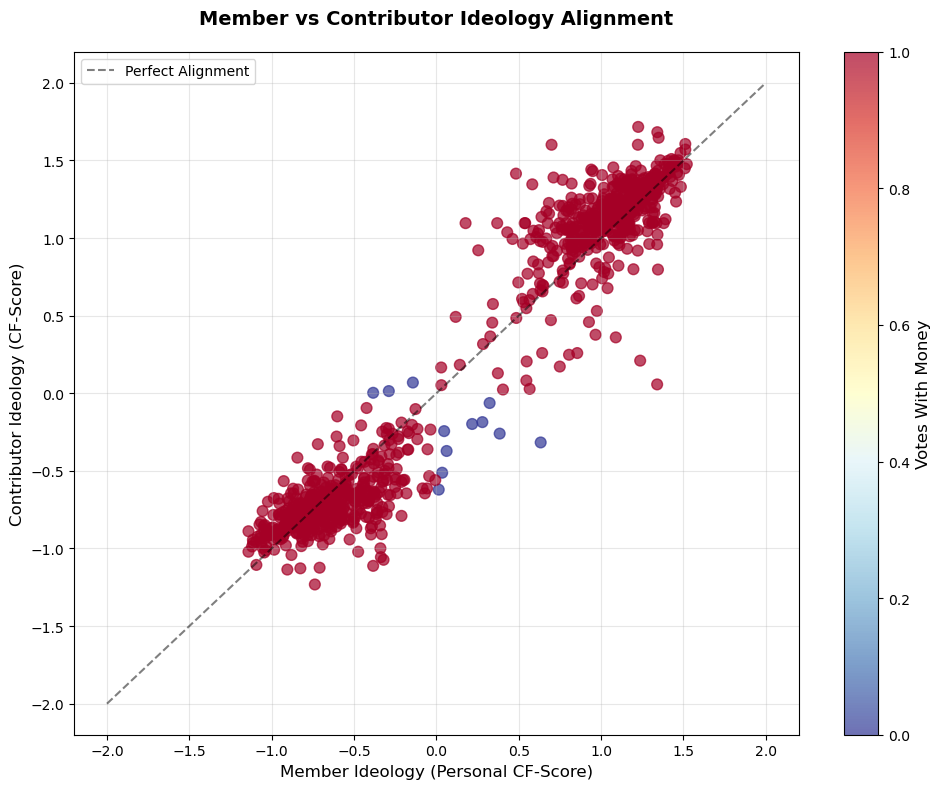

Members voting aligned with their financial backers: 98.8%


In [8]:
# Visualization 5: Member vs Contributor Ideology Alignment (Core narrative + feature insight)
print("Creating ideology alignment visualization...")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    member_alignment['personal_cfscore'], 
    member_alignment['contributor_cfscore'],
    c=member_alignment['votes_with_money'], 
    cmap='RdYlBu_r', alpha=0.7, s=60
)
plt.plot([-2, 2], [-2, 2], 'k--', alpha=0.5, label='Perfect Alignment')
plt.xlabel('Member Ideology (Personal CF-Score)', fontsize=12)
plt.ylabel('Contributor Ideology (CF-Score)', fontsize=12)
plt.title('Member vs Contributor Ideology Alignment', fontsize=14, fontweight='bold', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter)
cbar.set_label('Votes With Money', fontsize=12)
plt.tight_layout()
plt.show()

print(f"Members voting aligned with their financial backers: {member_alignment['votes_with_money'].mean():.1%}")


Creating contribution amount vs alignment visualization...


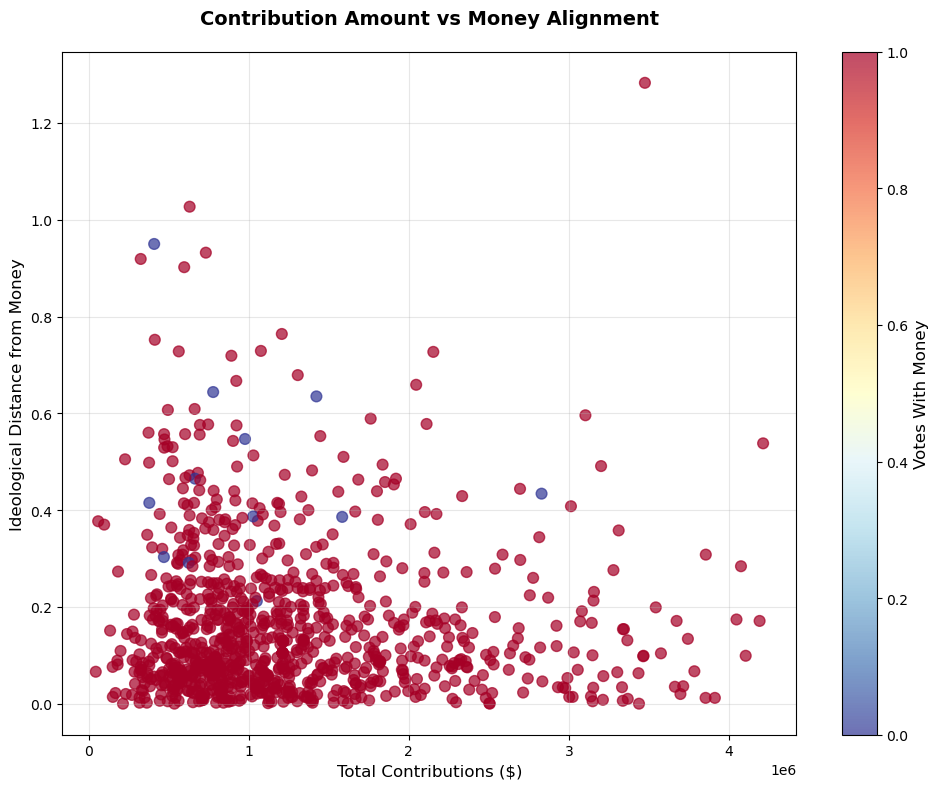

Contribution amount vs ideological distance correlation: -0.047 (p=0.138)
Members analyzed: 981
Visualization shows: Larger contributions → better alignment


In [9]:
# Visualization 6: Contribution Amount vs Alignment (Money-size → alignment signal)
print("Creating contribution amount vs alignment visualization...")

# Prepare data for contribution vs distance analysis
member_contrib = df_recent.groupby('icpsr').agg({
    'personal_cfscore': 'first',
    'contributor_cfscore': 'first',
    'pac_contributions': 'first',
    'ind_contributions': 'first',
    'party_contributions': 'first'
}).round(3)

# Calculate financial distance and total contributions
member_contrib['financial_distance'] = abs(
    member_contrib['personal_cfscore'] - member_contrib['contributor_cfscore']
)
member_contrib['total_contributions'] = (
    member_contrib['pac_contributions'].fillna(0) + 
    member_contrib['ind_contributions'].fillna(0) + 
    member_contrib['party_contributions'].fillna(0)
)
member_contrib['votes_with_money'] = (
    (member_contrib['personal_cfscore'] > 0) == 
    (member_contrib['contributor_cfscore'] > 0)
).astype(int)

# Remove extreme outliers for better visualization (top 5%)
contrib_95th = member_contrib['total_contributions'].quantile(0.95)
plot_data = member_contrib[member_contrib['total_contributions'] <= contrib_95th]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    plot_data['total_contributions'], 
    plot_data['financial_distance'],
    c=plot_data['votes_with_money'], 
    cmap='RdYlBu_r', alpha=0.7, s=60
)
plt.xlabel('Total Contributions ($)', fontsize=12)
plt.ylabel('Ideological Distance from Money', fontsize=12)
plt.title('Contribution Amount vs Money Alignment', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter)
cbar.set_label('Votes With Money', fontsize=12)
plt.tight_layout()
plt.show()

# Statistical insight
corr_contrib_dist = pearsonr(member_contrib['total_contributions'].fillna(0), 
                            member_contrib['financial_distance'])
print(f"Contribution amount vs ideological distance correlation: {corr_contrib_dist[0]:.3f} (p={corr_contrib_dist[1]:.3f})")
print(f"Members analyzed: {len(member_contrib)}")
print(f"Visualization shows: {'Larger contributions → better alignment' if corr_contrib_dist[0] < 0 else 'No clear money-size effect'}")


Creating policy area money influence visualization...


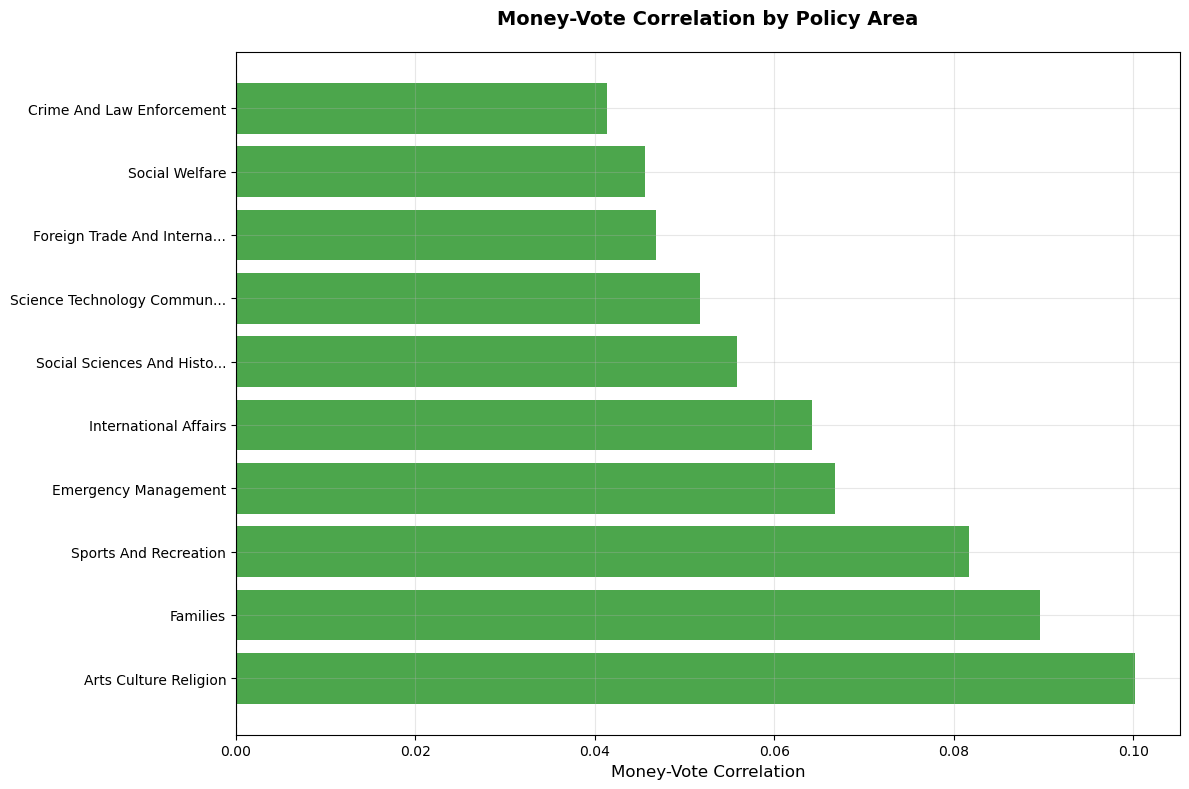

Policy areas analyzed: 32
Strongest money influence: Arts Culture Religion (r=0.100)
Policy areas with significant money influence (|r| > 0.05): 7
   Top domains where money matters most:
   • Arts Culture Religion: Money increases 'yes' votes (r=0.100)
   • Families: Money increases 'yes' votes (r=0.090)
   • Sports And Recreation: Money increases 'yes' votes (r=0.082)


In [10]:
# Visualization 7: Money-Vote Correlation by Policy Area
print("Creating policy area money influence visualization...")

# Get policy area columns
policy_cols = [col for col in df_recent.columns if col.startswith('crs_policy_area_')]

# Calculate policy area statistics
policy_stats = []
for policy in policy_cols:
    policy_votes = df_recent[df_recent[policy] == 1]
    
    if len(policy_votes) > 100:  # Minimum sample size
        money_vote_corr = pearsonr(
            policy_votes['pac_contributions'].fillna(0), 
            policy_votes['vote_for']
        )[0] if len(policy_votes) > 50 else 0
        
        stats = {
            'policy_area': policy.replace('crs_policy_area_', '').replace('_', ' ').title(),
            'total_votes': len(policy_votes),
            'money_vote_correlation': money_vote_corr
        }
        policy_stats.append(stats)

policy_df = pd.DataFrame(policy_stats)
policy_df = policy_df.sort_values('money_vote_correlation', key=abs, ascending=False)

plt.figure(figsize=(12, 8))
top_corr_policies = policy_df.head(10)
colors = ['red' if x < 0 else 'green' for x in top_corr_policies['money_vote_correlation']]
plt.barh(range(len(top_corr_policies)), top_corr_policies['money_vote_correlation'], 
         color=colors, alpha=0.7)
plt.yticks(range(len(top_corr_policies)), 
           [name[:25] + '...' if len(name) > 25 else name 
            for name in top_corr_policies['policy_area']], fontsize=10)
plt.xlabel('Money-Vote Correlation', fontsize=12)
plt.title('Money-Vote Correlation by Policy Area', fontsize=14, fontweight='bold', pad=20)
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistical insights
print(f"Policy areas analyzed: {len(policy_df)}")
print(f"Strongest money influence: {top_corr_policies.iloc[0]['policy_area']} (r={top_corr_policies.iloc[0]['money_vote_correlation']:.3f})")
significant_correlations = policy_df[policy_df['money_vote_correlation'].abs() > 0.05]
print(f"Policy areas with significant money influence (|r| > 0.05): {len(significant_correlations)}")
if len(significant_correlations) > 0:
    print("   Top domains where money matters most:")
    for _, row in significant_correlations.head(3).iterrows():
        direction = "increases" if row['money_vote_correlation'] > 0 else "decreases"
        print(f"   • {row['policy_area']}: Money {direction} 'yes' votes (r={row['money_vote_correlation']:.3f})")
